# **NHẬP MÔN HỌC MÁY**
## **PHASE 1**
### Lớp: CQ2022/24
### Họ và tên: Nguyễn Phạm Tú Uyên
### MSSV: 22120422
---

### Import

In [1]:
# import các thư viện cần thiết
import numpy as np 
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier,  VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

In [2]:
# Tắt các cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

### Đọc dữ liệu

Hàm đọc dữ liệu từ file json

In [3]:
def load_data(json_path, is_train=True):
    '''(str, bool) -> list
    Hàm này đọc dữ liệu từ file json và trả về một list các dictionary.
    Mỗi dictionary chứa các thông tin sau:
    - vid_id: id của video
    - start_time: thời gian bắt đầu của clip trong video
    - end_time: thời gian kết thúc của clip trong video
    - audio_embedding: numpy array chứa các đặc trưng âm thanh của clip
    - is_turkey: nhãn cho bài toán phân loại (nếu là train)

    Tham số
    -------
    json_path: đường dẫn đến file json chứa dữ liệu
    is_train: True nếu là dữ liệu train, False nếu là dữ liệu test
    '''

    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Mỗi mục là một dictionary chứa vid_id, start, end, audio_embedding, is_turkey nếu là tập train
    records = []

    for item in data:

        # audio_embedding là một list list 128 chiều, ta chuyển thành numpy array
        embedding = np.array(item['audio_embedding'])  # shape: (frames, 128)
        
        record = {
            'vid_id': item['vid_id'],
            'start_time': item['start_time_seconds_youtube_clip'],
            'end_time': item['end_time_seconds_youtube_clip'],
            'audio_embedding': embedding
        }
        
        if is_train:
            record['is_turkey'] = item['is_turkey']
        
        records.append(record)
    
    return records

Đọc dữ liệu từ file json

In [4]:
# Đọc dữ liệu train
train_data = load_data('./data/train.json', is_train=True)
print(f"Train samples: {len(train_data)}")

Train samples: 1195


### **I. Phát triển mô hình**

#### 1. Chuẩn bị dữ liệu

Hàm trích đặc trưng trung bình embedding cho danh sách samples.

In [5]:
def extract_features_labels(records):
    '''(list) -> tuple
    Trả về một tuple gồm hai phần:
    - X: numpy array chứa các đặc trưng âm thanh của các clip
    - y: numpy array chứa nhãn cho các clip (nếu có)
    Mỗi clip được biểu diễn bằng một numpy array 128 chiều, là trung bình của các đặc trưng âm thanh trong khoảng thời gian clip.
    Tham số
    -------
    records: list các dictionary chứa thông tin về các clip
    '''
    X = []
    y = []
    for r in records:
        avg_emb = r['audio_embedding'].mean(axis=0)
        X.append(avg_emb)
        if 'is_turkey' in r:
            y.append(r['is_turkey'])
    return np.stack(X), np.array(y)

# def extract_features_labels(records):
#     X = []
#     y = []
#     for r in records:
#         emb = r['audio_embedding']
#         mean_emb = emb.mean(axis=0)
#         max_emb = emb.max(axis=0)
#         std_emb = emb.std(axis=0)
#         features = np.concatenate([mean_emb, max_emb, std_emb])
#         X.append(features)
#         if 'is_turkey' in r:
#             y.append(r['is_turkey'])
#     return np.stack(X), np.array(y)

Chia tập train thành 3 phần train, validation và test (chọn tỉ lệ 70:15:15 vì dữ liệu cũng khá ít nên cho train nhiều dữ liệu để học hơn)

In [6]:
X, y = extract_features_labels(train_data)

# Chia train+val và test trước
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
# Chia tiếp train và val từ X_temp
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape[0])
print("Valid size:", X_valid.shape[0])
print("Test size:", X_test.shape[0])

Train size: 835
Valid size: 180
Test size: 180


#### 2. Huấn luyện mô hình
Trong bước này, thử nghiệm với 8 mô hình để xây dựng một **baseline model**. Mục tiêu là đánh giá nhanh hiệu suất của các mô hình khác nhau và tìm ra những mô hình có hiệu quả tốt nhất đối với dữ liệu. Sau đó, chọn ra một số mô hình tốt nhất để tiếp tục tối ưu. Các mô hình này được đánh giá trên tập valid với chỉ số **AUC** và được chọn dựa trên gợi ý ở [machine_learning_map](https://scikit-learn.org/stable/machine_learning_map.html) (Linear SVC -> KNeighbors Classifier -> SVC, Ensemble Classifiers).

In [7]:
# Danh sách các mô hình sẽ thử nghiệm
models = {
    'K-Nearest Neighbors' : KNeighborsClassifier(),
    'Support Vector Machine' : SVC(probability=True, random_state=42),
    'Logistic Regression' : LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'Gradient Boosting' : GradientBoostingClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'AdaBoost' : AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    'Bagging' :  BaggingClassifier(random_state=42)
}

Hàm huấn luyện các mô hình trên tập train

In [8]:
def train_models(models, X_train, y_train):
    trained_models = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])
        pipeline.fit(X_train, y_train)
        trained_models[name] = pipeline

    return trained_models

Huấn luyện

In [9]:
trained_models = train_models(models, X_train, y_train)

Đánh giá mô hình trên tập valid để chọn ra 3 mô hình tốt nhất

Hàm dự đoán xác suất từ các mô hình đã train

In [10]:
def predict_proba_models(trained_models, X_valid):
    results = {}
    for name, pipeline in trained_models.items():
        y_proba = pipeline.predict_proba(X_valid)[:, 1]
        results[name] = y_proba
    return results

Dự đoán

In [11]:
results = predict_proba_models(trained_models, X_valid)

Đánh giá các mô hình trên tập valid

In [12]:
auc_scores = {}
for name, y_proba in results.items():
    auc = roc_auc_score(y_valid, y_proba)
    auc_scores[name] = auc

# In theo thứ tự giảm dần
sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
for name, auc in sorted_auc:
    print(f'{name} ROC AUC on validation: {auc:.4f}')

Extra Trees ROC AUC on validation: 0.9881
Logistic Regression ROC AUC on validation: 0.9873
Random Forest ROC AUC on validation: 0.9872
K-Nearest Neighbors ROC AUC on validation: 0.9872
Support Vector Machine ROC AUC on validation: 0.9867
AdaBoost ROC AUC on validation: 0.9856
Gradient Boosting ROC AUC on validation: 0.9842
Bagging ROC AUC on validation: 0.9762


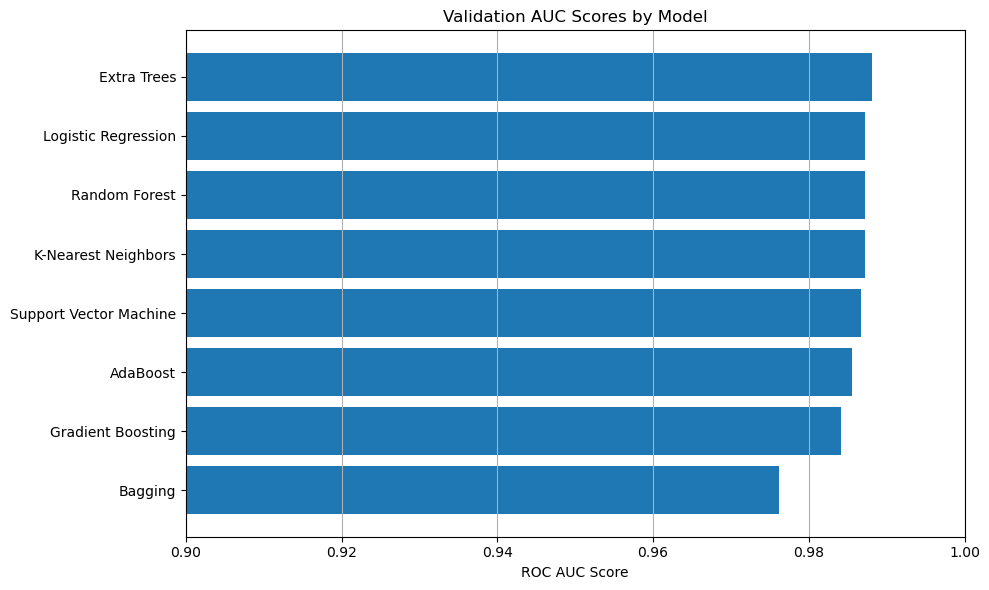

In [13]:
# Bar chart AUC
names = [name for name, _ in sorted_auc]
auc_values = [auc for _, auc in sorted_auc]

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], auc_values[::-1], color='#1f77b4')  
plt.xlim(0.9, 1.0) 
plt.xlabel('ROC AUC Score')
plt.title('Validation AUC Scores by Model')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Chọn 5 mô hình là ExtraTrees, LogisticRegression, Random Forest, K-Nearest Neighbors, Support Vector Machine.

#### 3. Tinh chỉnh siêu tham số

In [14]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_valid_scaled = scaler.transform(X_valid)            
X_test_scaled = scaler.transform(X_test)              

# 1. ExtraTreesClassifier tuning
param_grid_et = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] 
}

et = ExtraTreesClassifier(random_state=42)
grid_et = GridSearchCV(et, param_grid_et, cv=5, scoring='roc_auc', n_jobs=-1)
grid_et.fit(X_train_scaled, y_train)
print("ExtraTrees best params:", grid_et.best_params_)
print("ExtraTrees best CV AUC:", grid_et.best_score_)

# 2. SVM tuning
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True, random_state=42)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_svm.fit(X_train_scaled, y_train)
print("SVM best params:", grid_svm.best_params_)
print("SVM best CV AUC:", grid_svm.best_score_)

# 3. LogisticRegression tuning
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # 'l1' requires solver='liblinear' or 'saga', nếu muốn bạn có thể thử thêm
    'solver': ['lbfgs'],
    'max_iter': [1000]
}

lr = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)
print("LogisticRegression best params:", grid_lr.best_params_)
print("LogisticRegression best CV AUC:", grid_lr.best_score_)

# 4. RandomForestClassifier tuning
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] 
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)
print("RandomForest best params:", grid_rf.best_params_)
print("RandomForest best CV AUC:", grid_rf.best_score_)

# 5. KNeighborsClassifier tuning
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'p': [1, 2]
}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)  
grid_knn.fit(X_train_scaled, y_train)
print("KNeighbors best params:", grid_knn.best_params_)
print("KNeighbors best CV AUC:", grid_knn.best_score_)

ExtraTrees best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}
ExtraTrees best CV AUC: 0.9865058012664882
SVM best params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
SVM best CV AUC: 0.9841113784117071
LogisticRegression best params: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression best CV AUC: 0.9866878767317203
RandomForest best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
RandomForest best CV AUC: 0.9850222038749624
KNeighbors best params: {'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
KNeighbors best CV AUC: 0.9689585188489099


#### 4. Đánh giá trên valid để chọn mô hình tốt nhất và huấn luyện lại mô hình trên train và test.

Model                ROC AUC    Accuracy  
LogisticRegression   0.9902     0.9667
RandomForest         0.9888     0.9500
ExtraTrees           0.9874     0.9500
SVM                  0.9867     0.9611
KNeighbors           0.9850     0.9444


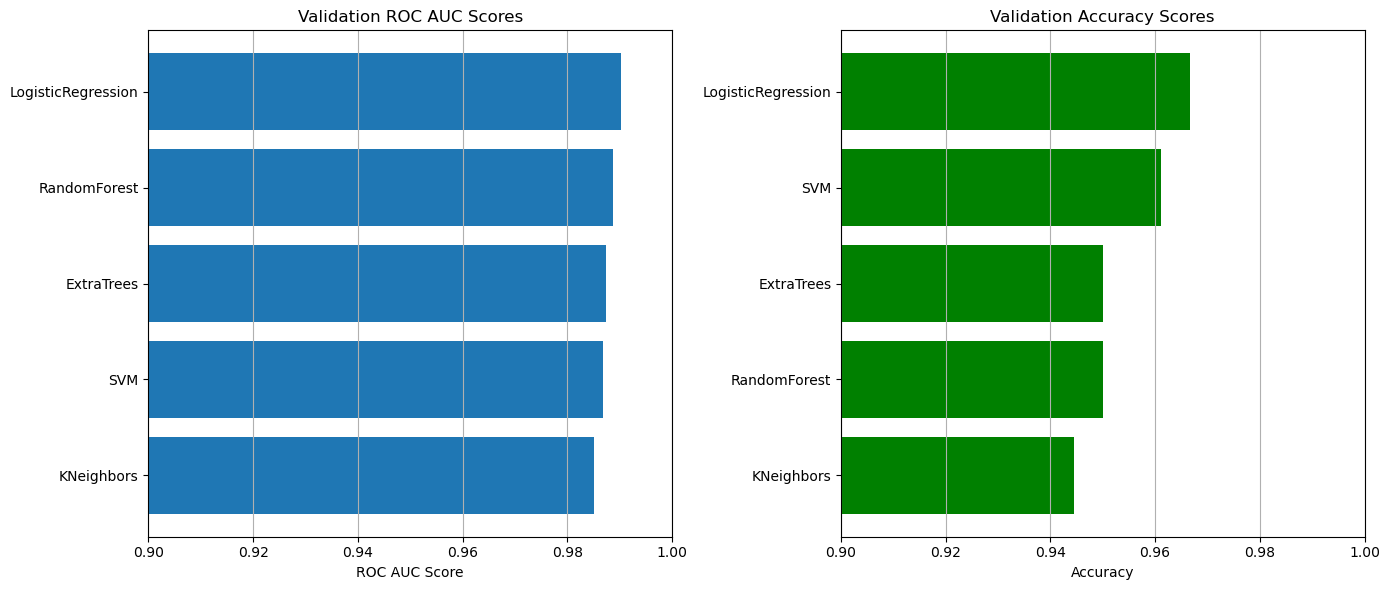

In [15]:
models_best = {
    'ExtraTrees': grid_et.best_estimator_,
    'SVM': grid_svm.best_estimator_,
    'LogisticRegression': grid_lr.best_estimator_,
    'RandomForest': grid_rf.best_estimator_,
    'KNeighbors': grid_knn.best_estimator_,
}

auc_scores = {}
acc_scores = {}

for name, model in models_best.items():
    # Dự đoán xác suất và nhãn
    y_prob = model.predict_proba(X_valid_scaled)[:, 1]
    y_pred = model.predict(X_valid_scaled)

    auc_scores[name] = roc_auc_score(y_valid, y_prob) # Tính ROC AUC
    acc_scores[name] = accuracy_score(y_valid, y_pred) # Tính Accuracy

# Sắp xếp cho ROC AUC
sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
sorted_names_auc = [name for name, _ in sorted_auc]
auc_values = [auc_scores[name] for name in sorted_names_auc]

# Sắp xếp cho Accuracy
sorted_acc = sorted(acc_scores.items(), key=lambda x: x[1], reverse=True)
sorted_names_acc = [name for name, _ in sorted_acc]
acc_values = [acc_scores[name] for name in sorted_names_acc]

# In kết quả
print(f"{'Model':<20} {'ROC AUC':<10} {'Accuracy':<10}")
for name, auc in sorted_auc:
    print(f"{name:<20} {auc:.4f}     {acc_scores[name]:.4f}")

# Trực quan hóa kết quả
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ROC AUC chart
axs[0].barh(sorted_names_auc[::-1], auc_values[::-1], color='#1f77b4')
axs[0].set_xlim(0.9, 1.0)
axs[0].set_title('Validation ROC AUC Scores')
axs[0].set_xlabel('ROC AUC Score')
axs[0].grid(axis='x')

# Accuracy chart
axs[1].barh(sorted_names_acc[::-1], acc_values[::-1], color='green')
axs[1].set_xlim(0.9, 1.0)
axs[1].set_title('Validation Accuracy Scores')
axs[1].set_xlabel('Accuracy')
axs[1].grid(axis='x')

plt.tight_layout()
plt.show()

- Logistic Regression là mô hình tốt nhất với ROC AUC = 0.9902 và Accuracy = 0.9667 cho thấy nó rất mạnh trong việc phân biệt giữa hai lớp.

- SVM tuy có ROC AUC thấp hơn một chút (0.9867) nhưng lại có accuracy khá cao (0.9611) gần bằng Logistic.

- Random Forest và Extra Trees có AUC tốt nhưng accuracy thấp hơn cho thấy có thể dự đoán xác suất tốt nhưng phân loại nhãn chưa thật sự tối ưu.

- KNN kém nhất cả về AUC lẫn accuracy.

Vì Logistic Regression đạt cả ROC AUC và Accuracy cao, trong khi SVM có độ chính xác gần tương đương nhưng quyết định phân loại có phần khác biệt. Do đó, ta thử kết hợp 2 mô hình này lại và đánh giá trên tập valid, xem xét xem kết quả có tốt hơn không.

In [16]:
# Ensemble Voting
ensemble = VotingClassifier(
    estimators=[
        #('RandomForest', grid_rf.best_estimator_),
        #('ExtraTrees', grid_et.best_estimator_),
        ('SVM', grid_svm.best_estimator_),
        ('LogisticRegression', grid_lr.best_estimator_),
    ],
    voting='soft'  # dựa trên xác suất dự đoán
)

ensemble.fit(X_train_scaled, y_train)

y_pred = ensemble.predict(X_valid_scaled)
y_prob = ensemble.predict_proba(X_valid_scaled)[:, 1]

acc = accuracy_score(y_valid, y_pred)
print(f'Ensemble Accuracy: {acc}')    
auc = roc_auc_score(y_valid, y_prob)
print(f'Ensemble ROC AUC: {auc}')

Ensemble Accuracy: 0.9722222222222222
Ensemble ROC AUC: 0.9908210096889342


Ta thấy Ensemble kết hợp từ Logistic Regression và SVM có cả Accuracy và ROC AUC cao vượt trội so với dùng mô một mình mô hình trước đó ta thấy kết quả là tốt nhất là Logistic Regression.

Do đó, ta sẽ chọn mô hình này làm mô hình tốt nhất để sử dụng. Giờ ta sẽ học lại trên cả train và valid để mô hình học được nhiều hơn, sau đó mới đánh giá cuối cùng trên tập test.

In [17]:
# Kết hợp train và valid
X_train_valid = np.concatenate([X_train, X_valid], axis=0)
y_train_valid = np.concatenate([y_train, y_valid], axis=0)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_valid_scaled = scaler.fit_transform(X_train_valid)

# Huấn luyện mô hình ensemble
ensemble.fit(X_train_valid_scaled, y_train_valid)

VotingClassifier(estimators=[('SVM',
                              SVC(C=1, gamma='auto', probability=True,
                                  random_state=42)),
                             ('LogisticRegression',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

### **II. Đánh giá mô hình**

Dự đoán xác suất trên tập test

In [18]:
y_test_proba = ensemble.predict_proba(X_test_scaled)[:, 1]  # xác suất lớp 1
y_test_pred = ensemble.predict(X_test_scaled)  # nhãn dự đoán

Đánh giá mô hình trên tập test

In [19]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_proba))

Accuracy: 0.9611111111111111
ROC AUC: 0.9929882712901581


Mô hình ensemble đạt Accuracy = 0.961 và ROC AUC = 0.993 trên tập test cuối, cho thấy khả năng phân loại chính xác cao và phân biệt tốt giữa hai lớp, kết quả ổn định.

### Dự đoán kết quả của tập test ẩn

Ta dự đoán kết quả của tập test ẩn và lưu lại.

In [20]:
import pandas as pd
# Đọc dữ liệu train
test_data = load_data('./data/test.json', is_train=False)

# Trích đặc trưng test
def extract_features_test(records):
    X = []
    vid_ids = []
    for r in records:
        avg_emb = r['audio_embedding'].mean(axis=0)
        X.append(avg_emb)
        vid_ids.append(r['vid_id'])
    X = np.stack(X)
    return X, vid_ids

X_test_hidden, test_vid_ids = extract_features_test(test_data)
X_test_hidden_scaled = scaler.transform(X_test_hidden)  # chuẩn hóa dữ liệu test

# Dự đoán nhãn test
y_test_pred = ensemble.predict_proba(X_test_hidden_scaled)[:, 1]  # xác suất lớp 1

# Tạo DataFrame theo định dạng sample_submission.csv
submission_df = pd.DataFrame({
    'vid_id': test_vid_ids,
    'is_turkey': y_test_pred
})

# Lưu file submission
submission_df.to_csv('result.csv', index=False)

submission_df.head(10)

,vid_id,is_turkey
0,pyKh38FXD3E,0.001166
1,THhP1idrWXA,0.000332
2,jsw3T6GY2Nw,0.030377
3,nFkXTMHcjMU,0.001256
4,Au8g9kAlrLQ,0.775801
5,tgk3DUpRI-w,0.013863
6,BczNwyCGlH4,0.010887
7,zB5eXpmJDTM,0.001225
8,099z8epFcfc,0.998269
9,lQ8DMnq415o,0.998438
